In [1]:
!pip install -q transformers
!pip install -q accelerate
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def process_cnn_dailymail(version="3.0.0", sample_size=1000):
    dataset = load_dataset("cnn_dailymail", version)
    
    train_data = dataset["train"].select(range(sample_size)) if sample_size else dataset["train"]
    
    stats = {
        "num_train": len(dataset["train"]),
        "num_validation": len(dataset["validation"]),
        "num_test": len(dataset["test"]),
        "avg_article_length": sum(len(item["article"].split()) for item in train_data) / len(train_data),
        "avg_summary_length": sum(len(item["highlights"].split()) for item in train_data) / len(train_data),
    }
    
    return dataset, stats

def visualize_cnn_dailymail(dataset, sample_size=1000):
    train_data = dataset["train"].select(range(sample_size)) if sample_size else dataset["train"]
    
    article_lengths = [len(item["article"].split()) for item in train_data]
    summary_lengths = [len(item["highlights"].split()) for item in train_data]
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.histplot(article_lengths, bins=50, color="blue", label="Article Lengths", kde=True)
    sns.histplot(summary_lengths, bins=50, color="orange", label="Summary Lengths", kde=True)
    plt.title("Distribution of Article and Summary Lengths")
    plt.xlabel("Length (in words)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [3]:
# Configs
BATCH_SIZE = 16
epochs = 3
learning_rate = 1e-4
weight_decay = 1e-4

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset Statistics:
num_train: 287113
num_validation: 13368
num_test: 11490
avg_article_length: 591.624
avg_summary_length: 42.767


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


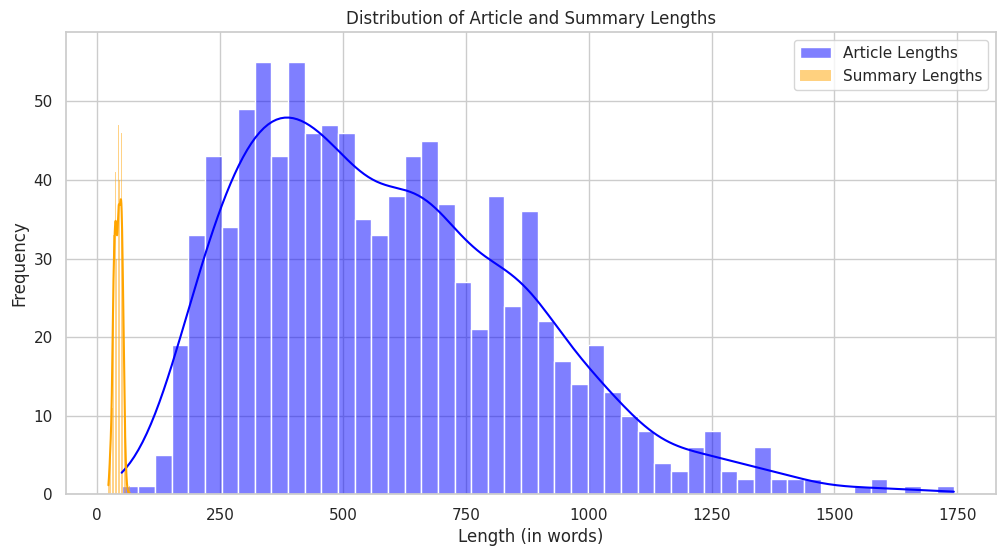

In [4]:
dataset, stats = process_cnn_dailymail(sample_size=1000)

print("Dataset Statistics:")
for key, value in stats.items():
    print(f"{key}: {value}")

visualize_cnn_dailymail(dataset, sample_size=1000)

In [5]:
from datasets import load_dataset
from transformers import T5Tokenizer
from torch.utils.data import DataLoader, Dataset
import torch

class CNNDailyMailDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_input_length=512, max_output_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        article = self.dataset[idx]["article"]
        summary = self.dataset[idx]["highlights"]

        input_ids = self.tokenizer.encode(
            "summarize: " + article,
            max_length=self.max_input_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        ).squeeze()

        labels = self.tokenizer.encode(
            summary,
            max_length=self.max_output_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        ).squeeze()

        return {
            "input_ids": input_ids,
            "labels": labels,
            "attention_mask": (input_ids != self.tokenizer.pad_token_id),
        }

def create_dataloader(version="3.0.0", split="train", batch_size=16, max_input_length=512, max_output_length=128):
    dataset = load_dataset("cnn_dailymail", version, split=split)

    tokenizer = T5Tokenizer.from_pretrained("t5-small")

    cnn_dataset = CNNDailyMailDataset(
        dataset=dataset,
        tokenizer=tokenizer,
        max_input_length=max_input_length,
        max_output_length=max_output_length,
    )

    dataloader = DataLoader(cnn_dataset, batch_size=batch_size, shuffle=True)

    return dataloader


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:

train_dataloader = create_dataloader(
                                    version="3.0.0",
                                    split="train",
                                    batch_size=BATCH_SIZE,
                                    max_input_length=512,
                                    max_output_length=128,
                                )
val_dataloader = create_dataloader(
                                    version="3.0.0",
                                    split="validation",
                                    batch_size=BATCH_SIZE,
                                    max_input_length=512,
                                    max_output_length=128,
                                )
for batch in train_dataloader:
    input_ids = batch["input_ids"]
    labels = batch["labels"]
    attention_mask = batch["attention_mask"]

    print(f"Input IDs Shape: {input_ids.shape}")
    print(f"Labels Shape: {labels.shape}")
    print(f"Attention Mask Shape: {attention_mask.shape}")
    break


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Input IDs Shape: torch.Size([16, 512])
Labels Shape: torch.Size([16, 128])
Attention Mask Shape: torch.Size([16, 512])


In [7]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import torch.nn as nn

class T5SummarizationModel(nn.Module):
    def __init__(self, model_name="t5-small", device="cuda" if torch.cuda.is_available() else "cpu"):
        super(T5SummarizationModel, self).__init__()
        self.model_name = model_name
        self.device = device

        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        return output

    def generate_summary(self, text, max_input_length=512, max_output_length=128, num_beams=4):
        input_ids = self.tokenizer.encode(
            "summarize: " + text,
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True,
        ).to(self.device)

        summary_ids = self.model.generate(
            input_ids,
            max_length=max_output_length,
            num_beams=num_beams,
            early_stopping=True,
        )

        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [8]:
model = T5SummarizationModel(model_name="t5-small")

example_text = (
    "The Apollo program was the third United States human spaceflight program carried out by NASA, "
    "which accomplished landing the first humans on the Moon from 1969 to 1972."
)

summary = model.generate_summary(example_text)
print("Generated Summary:", summary)

batch = next(iter(train_dataloader))
input_ids = batch["input_ids"].to(model.device)
attention_mask = batch["attention_mask"].to(model.device)
labels = batch["labels"].to(model.device)

outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
print("Loss:", outputs.loss)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generated Summary: the Apollo program was the third united states human spaceflight program carried out by NASA. it accomplished landing the first humans on the moon from 1969 to 1972.
Loss: tensor(9.8744, device='cuda:0', grad_fn=<NllLossBackward0>)


In [9]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, dataloader, optimizer, scheduler, device="cuda"):

    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


def validate_model(model, dataloader, device="cuda"):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [10]:
def plot_training_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="o")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/3


Train Loss: 1.1582 | Validation Loss: 1.1296
Epoch 2/3


Train Loss: 1.1212 | Validation Loss: 1.1179
Epoch 3/3


Train Loss: 1.1073 | Validation Loss: 1.1129


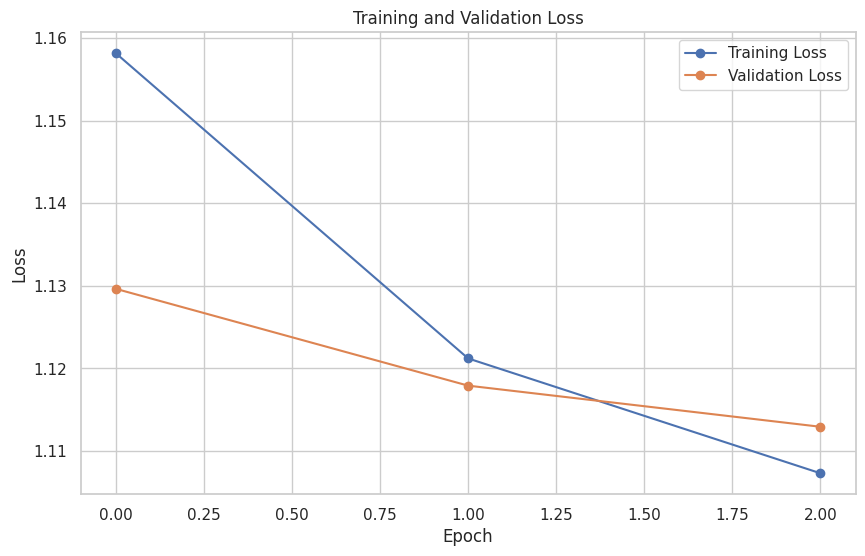

In [11]:
from torch.optim import AdamW
from transformers import get_scheduler
from accelerate import notebook_launcher
from accelerate import Accelerator
from torch import cuda



train_losses, val_losses = [], []

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=epochs * len(train_dataloader))

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss = train_model(model, train_dataloader, optimizer, scheduler, device=model.device)
    val_loss = validate_model(model, val_dataloader, device=model.device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

plot_training_loss(train_losses, val_losses)

